In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Pseudocode and Goals of Bandit Algorithms

```
GOALS:
input - the arm chosen by the player
objective - to maximize reward which is determined by minimizing regret
constraints - 
model - varies

EPSILON GREEDY
for t = 1...numTurns:
  flip a coin with probability epsilon of heads and 1 - epsilon of tails
  if heads:
    pull a random arm
  else:
    calculate the arm with the best experimental mean
    pull the arm with the best experimental mean

UCB
first k turns: initialize experimental means by pulling each arm once
for t = k+1...numTurns:
  for i = 1...k:
    calculate a(i, t) = 2 * log(t / p(i, t))
  pull arm i that maximizes experimental mean + a(i, t)

```



In [ ]:
# Function that graphs the average reward of an algorithm over time
# Also graphs a barchart to show the frequency at which particular arms are chosen

def plot_history(history):
  rewards = history["rewards"]
  average_rewards = history["average_rewards"]
  chosen_arms = history["arms"]

  fig = plt.figure(figsize=[30, 8])

  ax2 = fig.add_subplot(121)
  ax2.plot(average_rewards, label = "average rewards")
  ax2.set_title("Average Rewards")
  ax2.set_xlabel("Iteration")
  ax2.set_ylabel("Reward")

  ax3 = fig.add_subplot(122)
  ax3.bar([i for i in range(len(chosen_arms))], chosen_arms, label = "chosen arms")
  ax3.set_title("Chosen Actions")
  ax3.set_xlabel("Arm #")
  ax3.set_ylabel("Number of times selected")  

In [ ]:
class Env():
  def __init__(self, rewards, deviations):
    self.rewards = rewards
    self.deviations = deviations
    self.k = len(rewards)

  def choose_arm(self, arm):
    sign = random.randint(0,1)*2-1

    # Choose arm and returns a value that lies in its distribution
    return self.rewards[arm] + sign*random.randint(0, self.deviations[arm])

In [ ]:
environment = Env(rewards=[10, 8, 5, 1, 8], deviations=[5, 4, 25, 3, 7])

# Random Agent

In [ ]:
# This agent simply chooses random arm
class RandomAgent():
  def __init__(self, env, max_iterations=2000):
    self.env = env
    self.iterations = max_iterations

  def act(self):
    arm_counts = np.zeros(self.env.k)
    rewards = []
    average_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.k)
      reward = self.env.choose_arm(arm)
      
      arm_counts[arm] += 1
      rewards.append(reward)
      average_rewards.append(sum(rewards) / len(rewards))
    
    return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards}

In [ ]:
random_agent = RandomAgent(env=environment, max_iterations=2000)
RA_history = random_agent.act()
print(f"TOTAL REWARD : {sum(RA_history['rewards'])}")

TOTAL REWARD : 13187


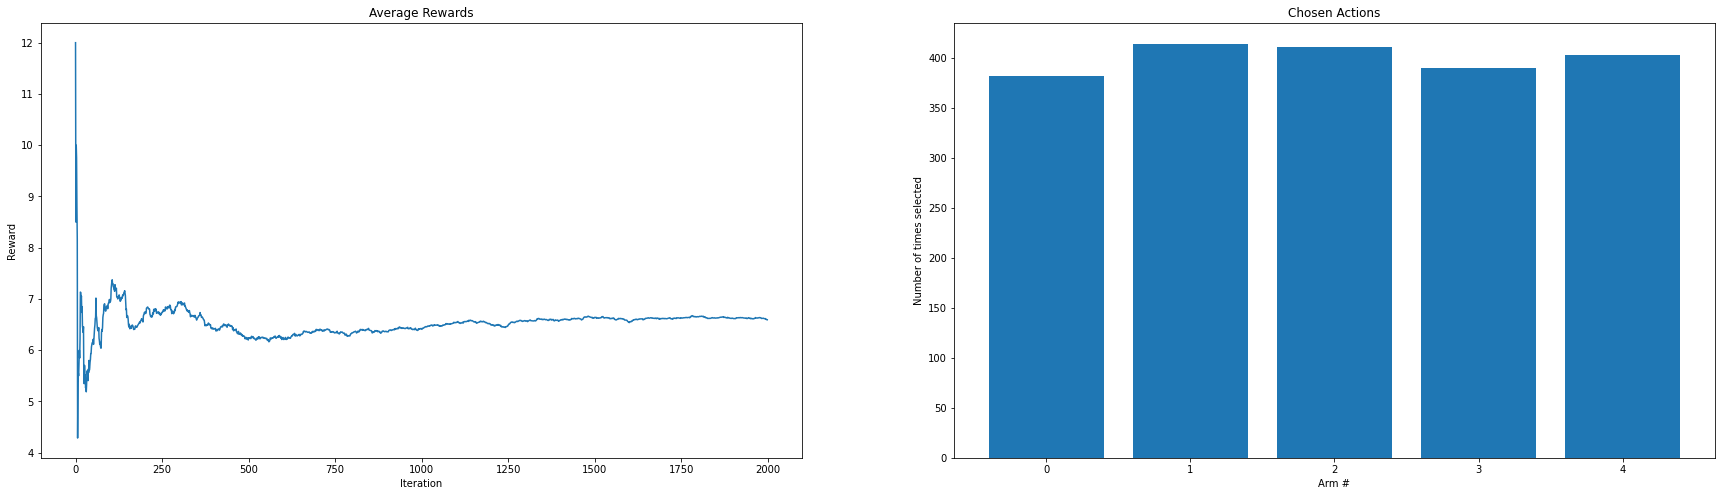

In [ ]:
plot_history(RA_history)

# Clearly here arms are chosen at random signified by the bars of equal heights and a relatively low average reward

# Epsilon Greedy Agent

In [ ]:
class EpsilonGreedyAgent():
  def __init__(self, env, max_iterations=2000, epsilon=0.1):
    self.env = env
    self.iterations = max_iterations
    self.epsilon = epsilon
  
  def act(self):
    q_values = np.zeros(self.env.k)
    arm_rewards = np.zeros(self.env.k)
    arm_counts = np.zeros(self.env.k)

    rewards = []
    average_rewards = []

    for i in range(1, self.iterations + 1):
      arm = np.random.choice(self.env.k) if np.random.random() < self.epsilon else np.argmax(q_values)
      reward = self.env.choose_arm(arm)

      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]

      rewards.append(reward)
      average_rewards.append(sum(rewards)/len(rewards))

    return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards}

In [ ]:
epsilon_greedy_agent = EpsilonGreedyAgent(env=environment, max_iterations=2000, epsilon=0.1)
EG_history = epsilon_greedy_agent.act()
print(f"TOTAL REWARD : {sum(EG_history['rewards'])}")

TOTAL REWARD : 19279


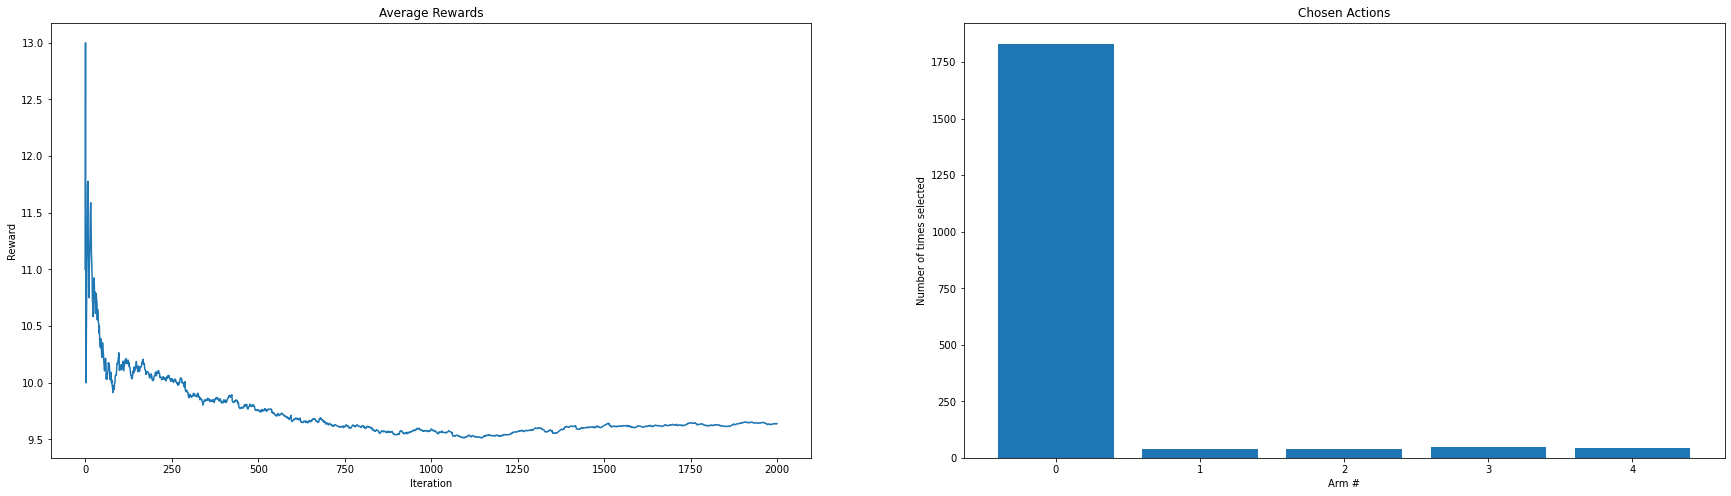

In [ ]:
plot_history(EG_history)

# Upper Confidence Bound (UCB) Agent

In [ ]:
class UpperConfidenceBoundAgent():
  def __init__(self, env, max_iterations=2000):
    self.env = env
    self.iterations = max_iterations
  
  def act(self):
    q_values = np.zeros(self.env.k)
    arm_rewards = np.zeros(self.env.k)
    arm_counts = np.zeros(self.env.k)

    rewards = []
    average_rewards = []

    #traverse every arm once
    for arm in range(self.env.k):
      reward = self.env.choose_arm(arm)

      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]

    for i in range(1, self.iterations + 1):
      # arm = np.random.choice(self.env.k) if np.random.random() < self.epsilon else np.argmax(q_values)
      arm = 0
      cur = 1000000000000
      # finds action where quantity u + hoffdings-constant is maximized
      for a in range(self.env.k):
        UCB = q_values[arm] + np.sqrt((2*np.log(i))/arm_counts[a])
        if UCB > cur:
          cur = UCB
          arm = a

      reward = self.env.choose_arm(arm)

      arm_rewards[arm] += reward
      arm_counts[arm] += 1
      q_values[arm] = arm_rewards[arm]/arm_counts[arm]

      rewards.append(reward)
      average_rewards.append(sum(rewards)/len(rewards))

    return {"arms" : arm_counts, "rewards": rewards, "average_rewards": average_rewards}

In [ ]:
UCB_agent = UpperConfidenceBoundAgent(env=environment, max_iterations=2000)
UCB_history = UCB_agent.act()
print(f"TOTAL REWARD : {sum(UCB_history['rewards'])}")

TOTAL REWARD : 20068


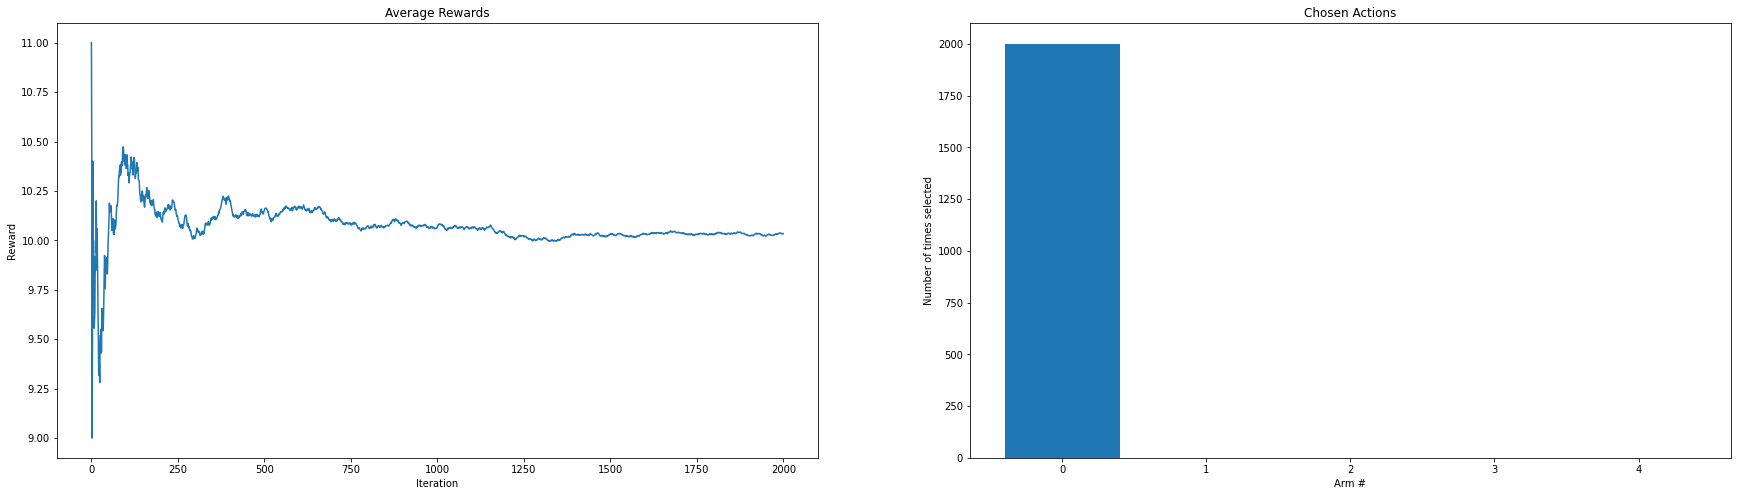

In [ ]:
plot_history(UCB_history)

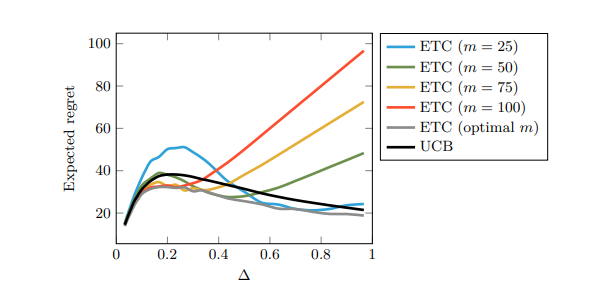

## Understanding this graph fully
In this graph, the x-axis (delta) represents the sub-optimality gap, or the gap between arm #2's reward and the optimal reward. This is graphed against the y-axis of regret. It makes sense that regret is very small when delta is small as the gap between the 2 arms is so little that it doesn't matter which arm the algorithm picks. However, as delta increases, the arm the algorithm chooses becomes more important thus leading to an increase in regret. But, after peaking, the regret begins to dip down again. I believe this is because the gap between optimal and suboptimal is getting so large that it is increasingly noticable for the algorithm to make adjustments in fewer trials leading to less and less regret. Also, the graph shows how the rate of regret varies for the size of m (or number of rounds chosen to explore) compared to the UCB method.